# Document Entity Extraction 

# Workflow for preprocessing
```
1: Rotate image
2: Straighten the image
3: External Contour Detection
4: Masking
5: Straighten the image

```
The steps 3 to 5 are added in order to deal with images having extra space around the document.

# Libraries to be installed
1. Opencv : For image manipulation/reading images
2. Numpy : Opencv handles images using ndimension arrays. Numpy is used for vectorized manipulations

In [0]:
!pip install numpy
!pip install opencv-python

# Installing tesseract-ocr


In [0]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,386 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

# Mounting Google Drive for images

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/images/"


a.tif
h_180.JPG
h_180_right_skewed.JPG
h_270.JPG
h_90.JPG
h_baap.JPG
h_border.jpg
h_border_left.JPG
h_border_top_right.JPG
h_cropped.JPG
h_double.jpg
h.JPG
h_left_skewed.JPG
h_lighting.JPG
h_right_skewed.JPG
https___blogs-images.forbes.com_kellyphillipserb_files_2014_02_W2.jpg
master.PNG


In [0]:
import os
os.getcwd()
path = '/content/drive/My Drive/images/'
os.chdir(path)
os.getcwd()

'/content/drive/My Drive/images'

# Importing Libraries


In [0]:
import cv2
import numpy as np
import re

In [0]:
# For code to work on Colab

import matplotlib.pyplot as plt
%matplotlib inline
import pytesseract

# Defining Functions

In [0]:
def plot_before_after(before, title ,after):
  """
  :param before: Before correction image
  :param before: After correction image
  :param Title: Name of the image
  """
  
  plt.figure(figsize=(18,25))
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(label = "Before : "+title)


  plt.subplot(1, 2, 2)
  plt.imshow(after,cmap='Greys_r')
  plt.axis('off')
  plt.title(label = 'After : ' +title)
  plt.show()

In [0]:
def detect_orientation(image):
    """
    Returns correct oriented image
    :param image: Input image
    """
    newdata = pytesseract.image_to_osd(image)
    rotation = int(re.search('(?<=Rotate: )\\d+', newdata).group(0))
    # print("Rotation degrees : ", rotation)
    return rotate_img(image, rotation)


def rotate_img(image, degrees):
    """
     Returns image rotated to the angle provided by detect_orientation
    :param image: The input image
    :param degrees: Angle to rotate
    :return Corrected image
    """
    if degrees == 90:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif degrees == 180:
        return cv2.rotate(image, cv2.ROTATE_180)
    elif degrees == 270:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif degrees == 0:
        return image
    else:
        print("DEGREE = ", degrees)


def straighten(image):
    """
     Applies straightening to an image
    :param image : Input image
    :return Straightened image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated

def straighten_thresh(image):
    """Applies straightening to an image
    :param image : Input threshold image
    :return Straightened image
    """
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # print("Straightening angle : ", angle)
    return rotated            

In [0]:
def extract_image(image):
  """
  Returns borderless image
  :param image : Image with border
  :returns borderless image
  """
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  re, img = cv2.threshold(img,180, 255, cv2.THRESH_BINARY)
  cont, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  area = 0
  biggest_cont = cont[0][0]
  peri = cv2.approxPolyDP(cont[0][0], 0.1, False)

  for i in cont:
      area1 = cv2.contourArea(i)
      if area1 > area:
          peri = cv2.approxPolyDP(i, 0.1, True)
          area = area1
          biggest_cont = i

  mask = np.zeros((image.shape[0], image.shape[1]),dtype=np.uint8)
  cv2.drawContours(mask, [biggest_cont], -1, (255, 255, 255), 2)
  sub_image = img - mask
  st_sub_images = straighten_thresh(sub_image)
  thresh = cv2.threshold(st_sub_images,1,255,cv2.THRESH_BINARY)[1]
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  if len(contours) == 1:
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    st_sub_images = st_sub_images[y:y+h,x:x+w]
  return st_sub_images

#Driver Function

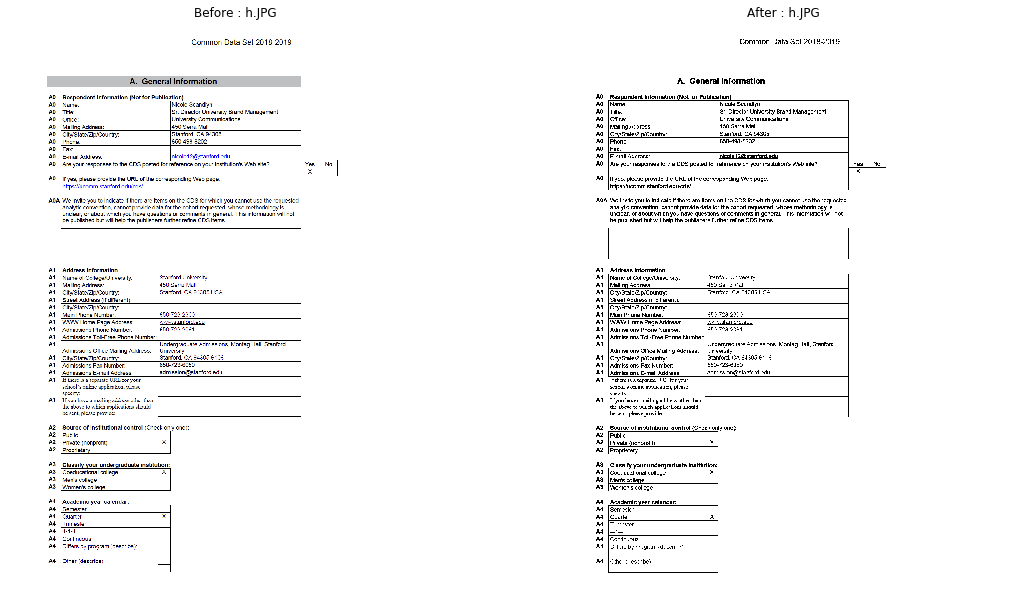

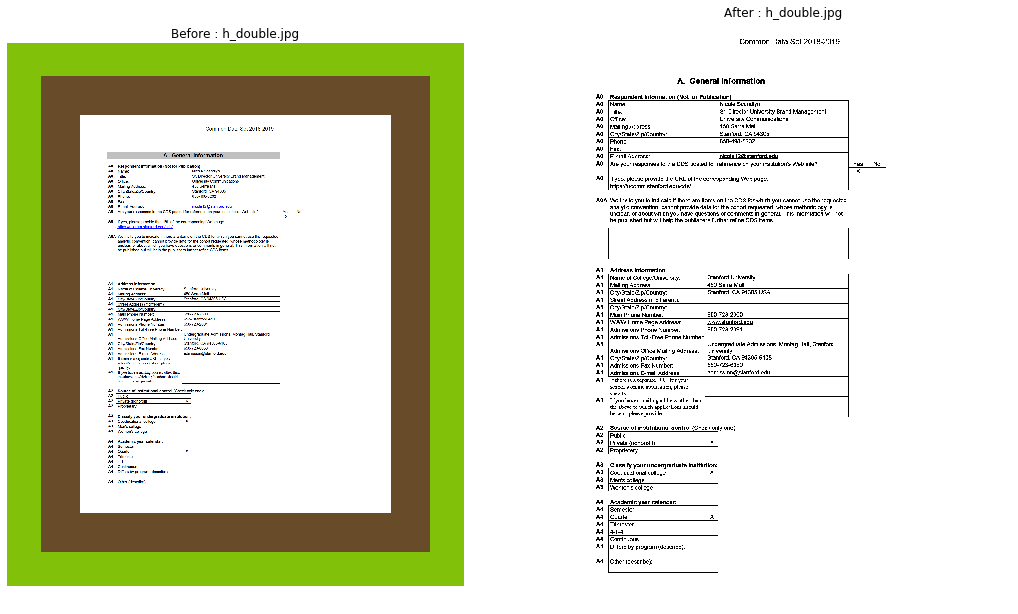

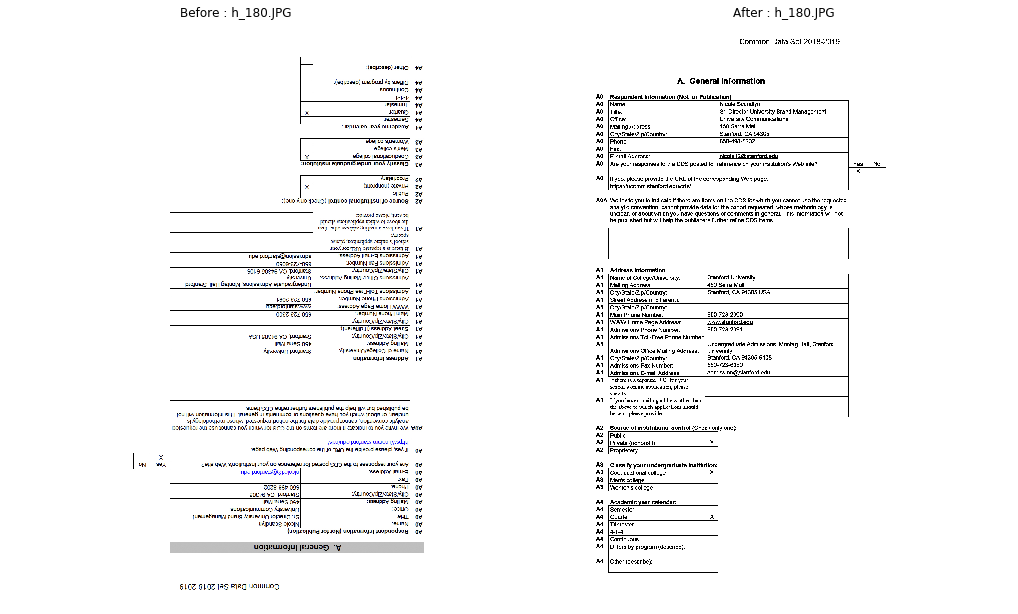

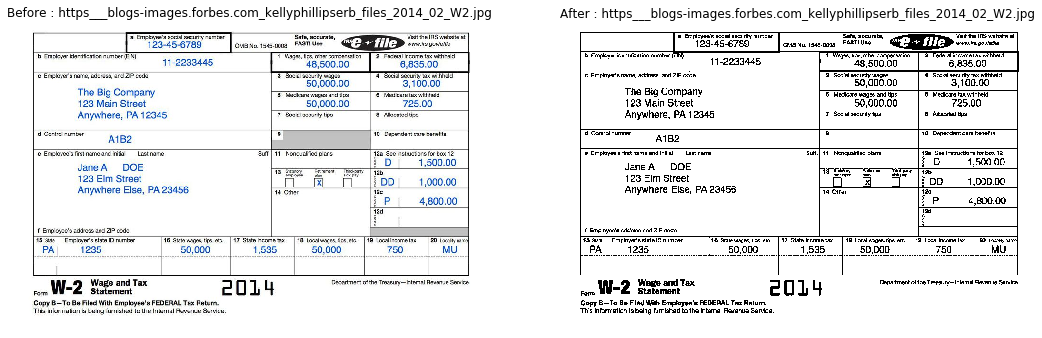

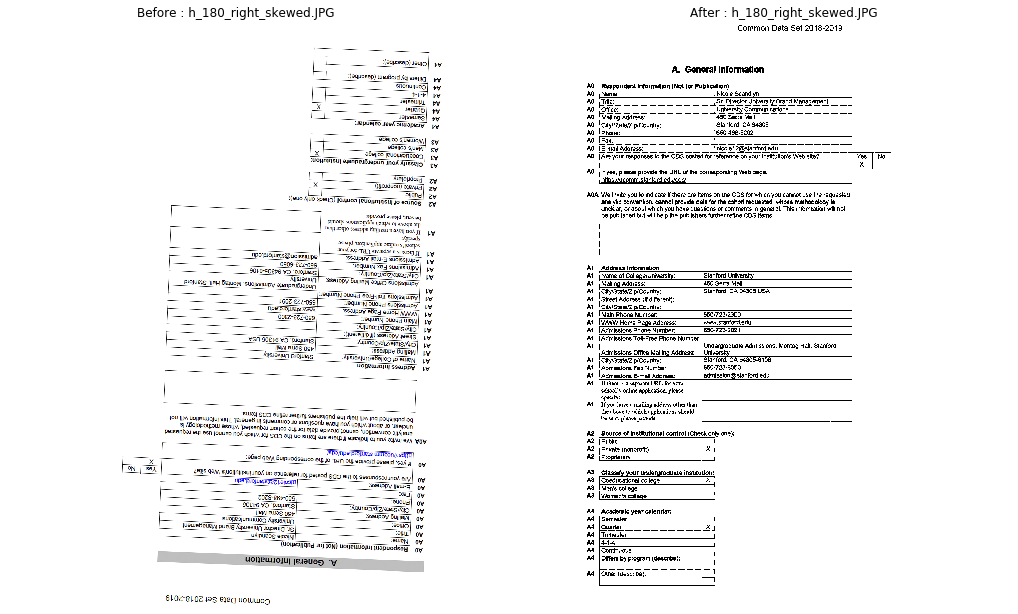

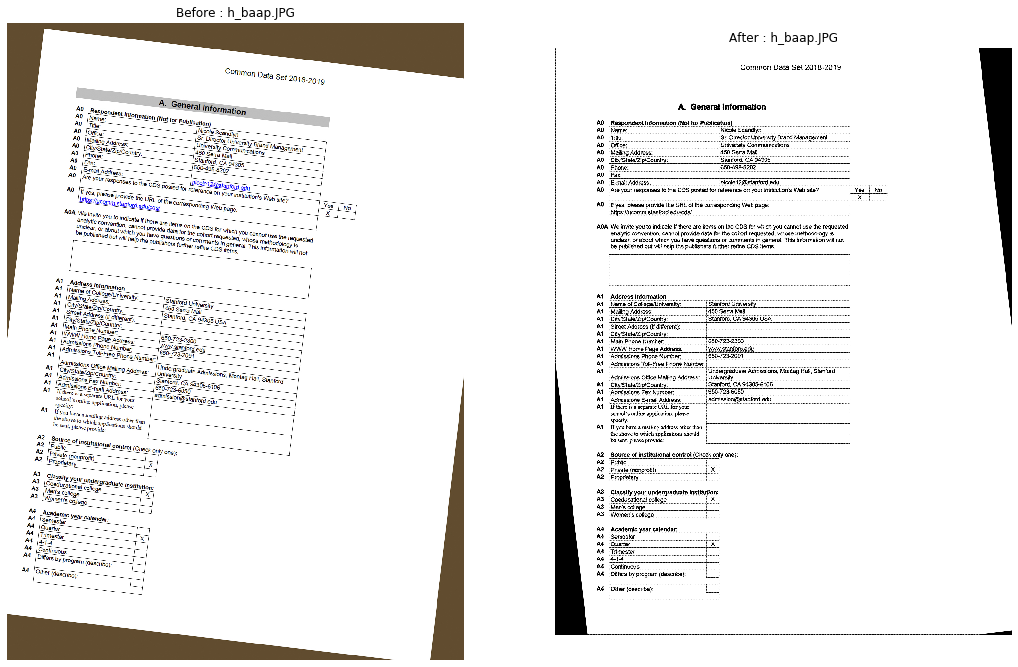

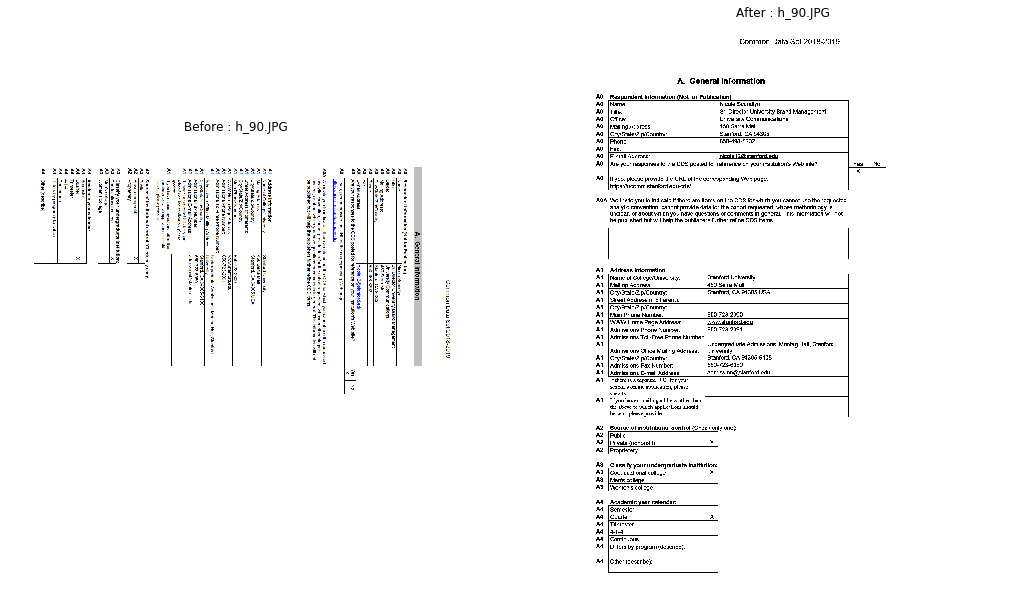

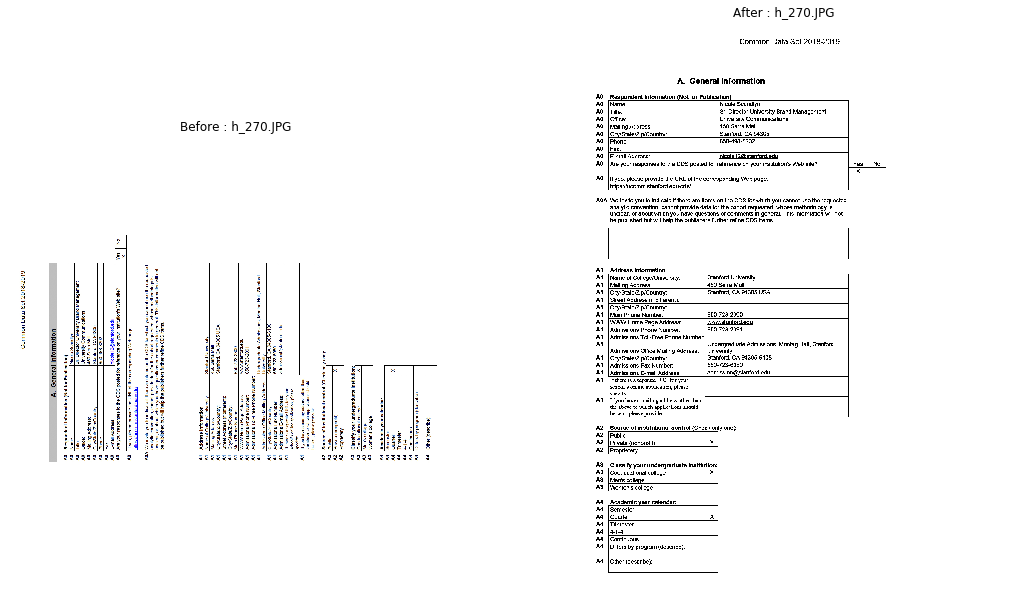

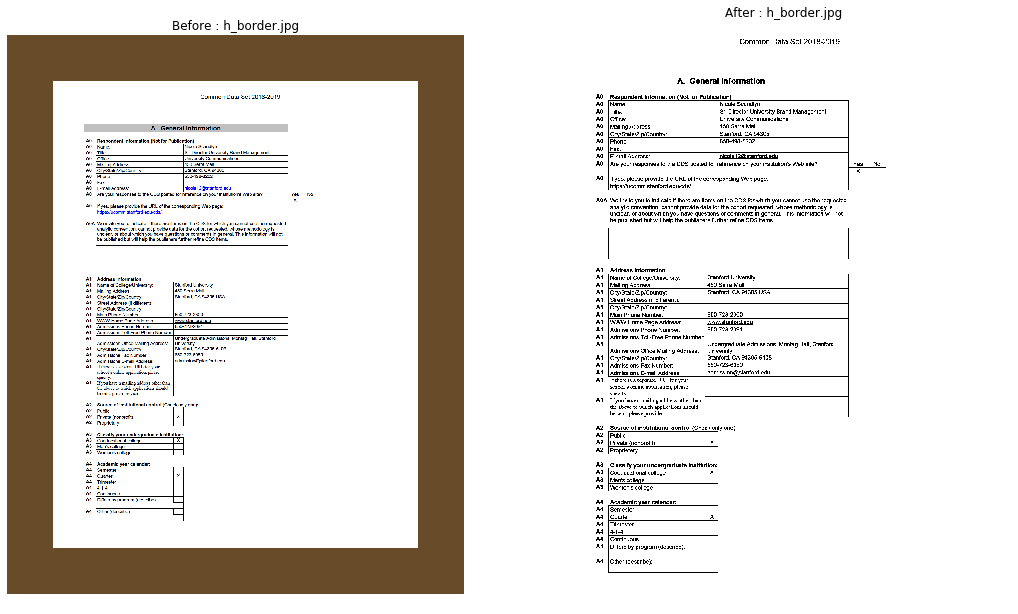

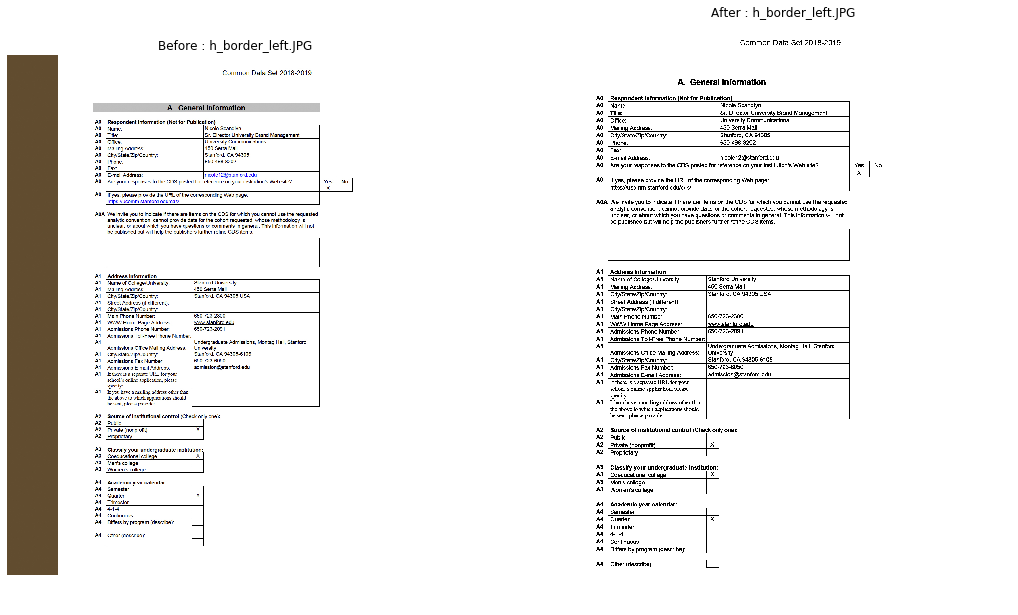

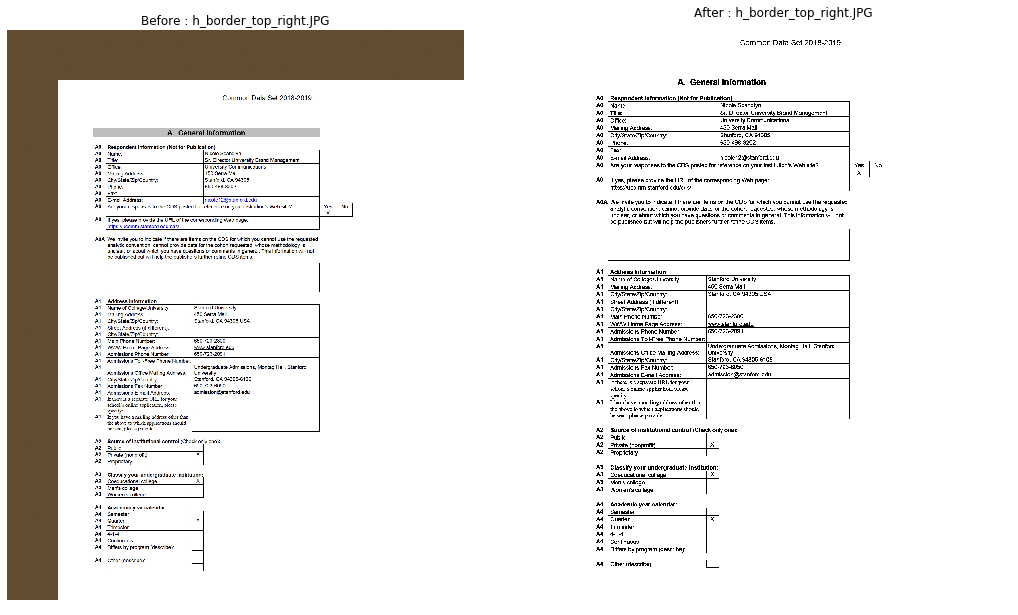

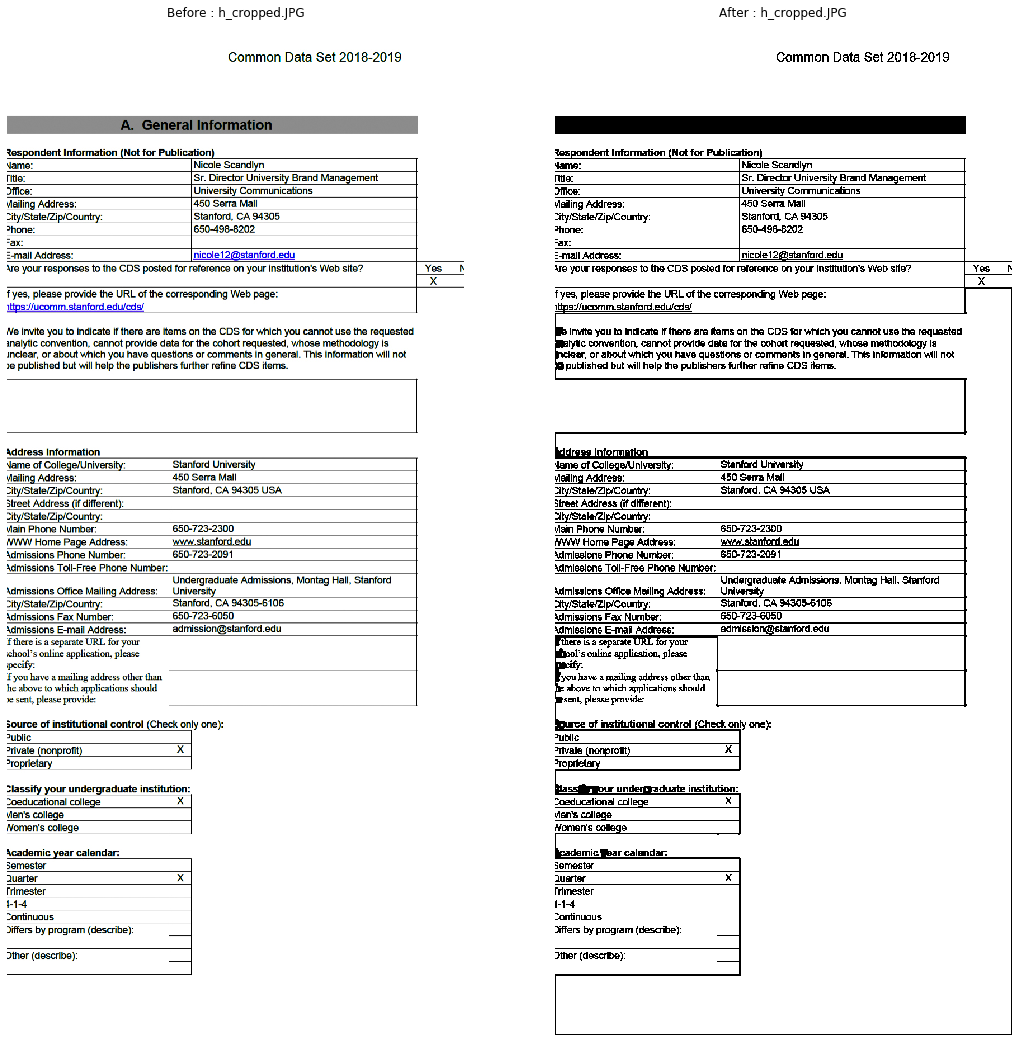

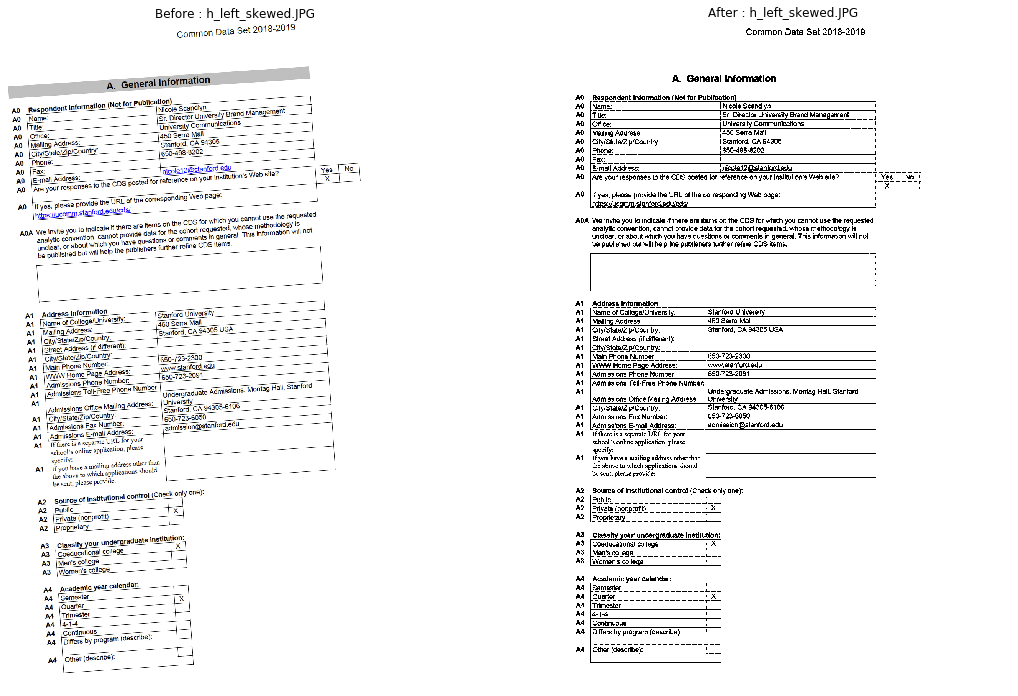

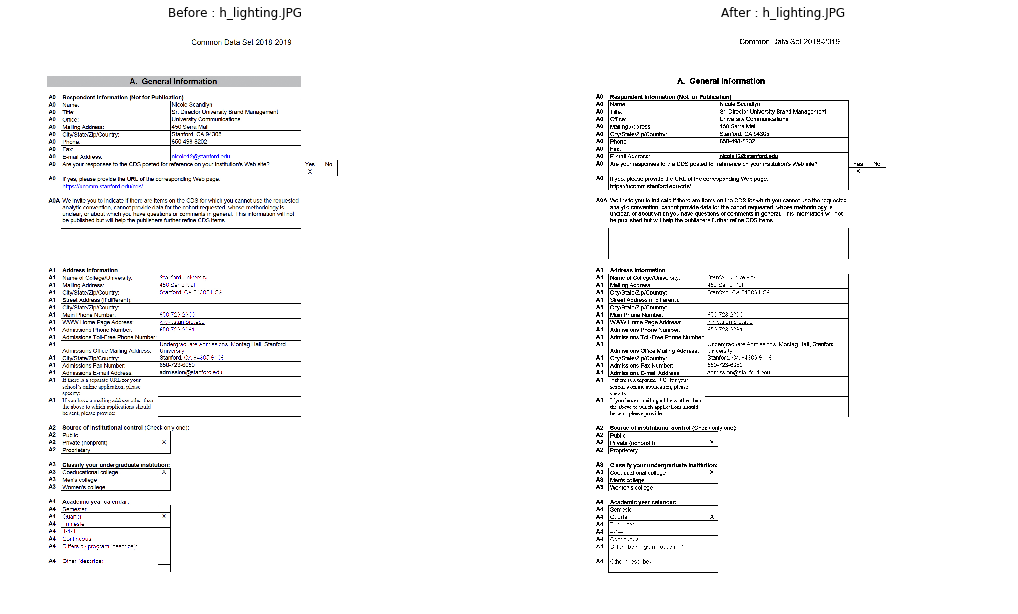

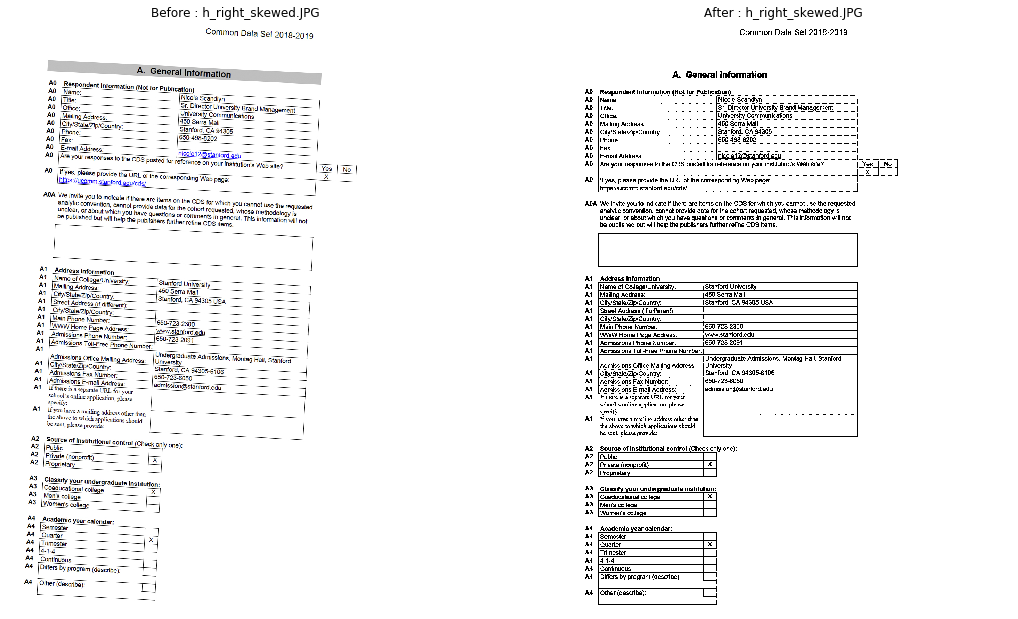

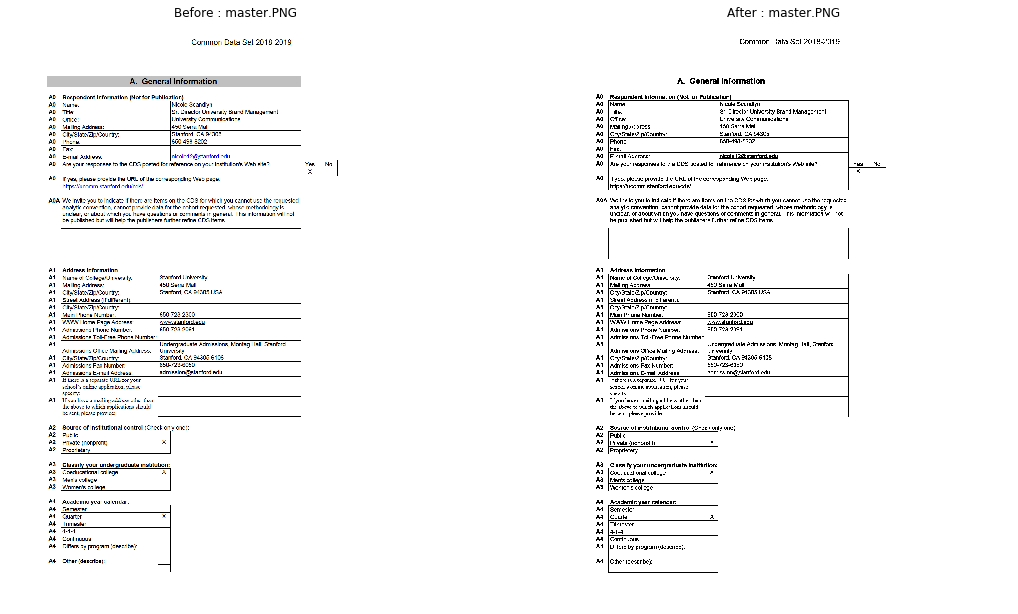

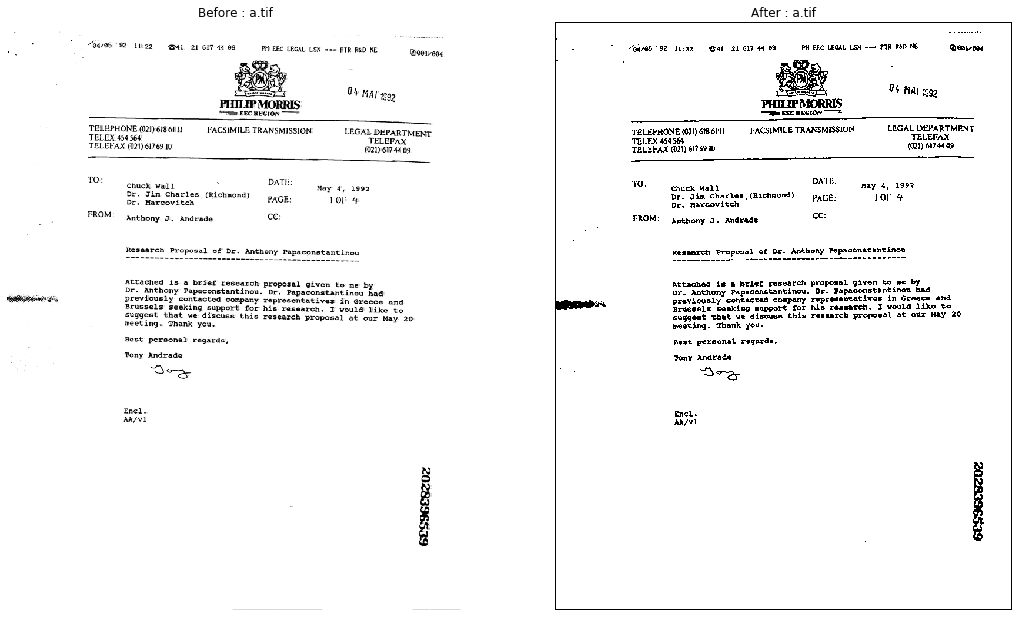

In [0]:
for image_name in os.listdir(path):
  img_before = cv2.imread(image_name)
  img2 = detect_orientation(img_before)
  img2 = straighten(img2)
  img_after = extract_image(img2)
  plot_before_after(img_before,image_name,img_after)